In [1]:
from google.colab import drive
drive.flush_and_unmount()
!rm -rf /content/drive/*
drive.mount('/content/drive')


Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


In [2]:
import os
import numpy as np
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K




In [3]:
# Function to load all images from a folder
def load_images_from_folder(folder, img_size=(128, 128)):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, img_size)

            # Convert to grayscale if needed (optional)
            # img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            # Ensure the image has the right shape (H, W, C)
            if len(img.shape) == 3:  # Color image
                images.append(img)
            elif len(img.shape) == 2:  # Grayscale image
                images.append(np.expand_dims(img, axis=-1))  # Add channel dimension
            else:
                print(f"Skipping {filename}: Unsupported image shape {img.shape}")

    print(f"Loaded {len(images)} images from {folder}")
    return np.array(images)

# Paths to the benign and malignant directories
benign_dir = "/content/drive/MyDrive/Kaggle_data/benign"
malignant_dir = "/content/drive/MyDrive/Kaggle_data/malignant"

# Load images from benign and malignant folders
benign_images = load_images_from_folder(benign_dir)
malignant_images = load_images_from_folder(malignant_dir)

# Combine the images
images = np.concatenate((benign_images, malignant_images), axis=0)

# Normalize images (0-1)
images = images.astype(np.float32) / 255.0  # Ensure correct dtype for normalization

# Shuffle images
np.random.shuffle(images)

print(f"Total images loaded: {images.shape[0]}")

Loaded 1800 images from /content/drive/MyDrive/Kaggle_data/benign
Loaded 1505 images from /content/drive/MyDrive/Kaggle_data/malignant
Total images loaded: 3305


In [4]:
benign_images = benign_images.astype(np.float32) / 255.0
malignant_images = malignant_images.astype(np.float32) / 255.0

In [5]:
# Function to generate distinct synthetic masks for benign and malignant images
def generate_synthetic_masks(benign_images, malignant_images, threshold=128):
    masks = []

    # Generate benign masks (diffused or low-intensity masks)
    for image in benign_images:
        image_uint8 = (image * 255).astype(np.uint8)
        gray_image = cv2.cvtColor(image_uint8, cv2.COLOR_BGR2GRAY)
        _, mask = cv2.threshold(gray_image, threshold - 30, 255, cv2.THRESH_BINARY)  # Lower threshold for benign
        mask = cv2.GaussianBlur(mask, (15, 15), 0)  # Diffuse edges for benign images
        mask = cv2.resize(mask, (128, 128))
        masks.append(mask / 255.0)

    # Generate malignant masks (higher intensity, more focused regions)
    for image in malignant_images:
        image_uint8 = (image * 255).astype(np.uint8)
        gray_image = cv2.cvtColor(image_uint8, cv2.COLOR_BGR2GRAY)
        _, mask = cv2.threshold(gray_image, threshold + 30, 255, cv2.THRESH_BINARY)  # Higher threshold for malignant
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, np.ones((5, 5), np.uint8))  # Enhance edges for malignant
        mask = cv2.resize(mask, (128, 128))
        masks.append(mask / 255.0)

    return np.array(masks).reshape(-1, 128, 128, 1)

# Generate synthetic masks for the benign and malignant images
lesion_masks = generate_synthetic_masks(benign_images, malignant_images)

# Combine benign and malignant images for final dataset
images = np.concatenate((benign_images, malignant_images), axis=0)

# Shuffle images and masks together
shuffled_indices = np.random.permutation(len(images))
images = images[shuffled_indices]
lesion_masks = lesion_masks[shuffled_indices]

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, lesion_masks, test_size=0.2, random_state=42)

# Print shapes of training and validation datasets
print(f"Training images shape: {X_train.shape}, Training masks shape: {y_train.shape}")
print(f"Validation images shape: {X_val.shape}, Validation masks shape: {y_val.shape}")

Training images shape: (2644, 128, 128, 3), Training masks shape: (2644, 128, 128, 1)
Validation images shape: (661, 128, 128, 3), Validation masks shape: (661, 128, 128, 1)


In [12]:
import numpy as np
from sklearn.metrics import adjusted_rand_score, cohen_kappa_score

def jaccard_coef(y_true, y_pred, smooth=1e-10, threshold=0.5):
    """
    Calculate the Jaccard coefficient (Intersection over Union).

    Parameters:
    - y_true: Ground truth binary mask.
    - y_pred: Predicted binary mask.
    - smooth: Smoothing factor to avoid division by zero.
    - threshold: Threshold to convert predictions to binary.

    Returns:
    - Jaccard coefficient value.
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Apply threshold to convert predictions to binary
    y_pred = (y_pred > threshold).astype(int)

    # Flatten the arrays
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()

    # Calculate intersection and union
    intersection = np.sum(y_true_f * y_pred_f)
    union = np.sum(y_true_f) + np.sum(y_pred_f) - intersection

    # Calculate the Jaccard coefficient (IoU)
    jac = (intersection + smooth) / (union + smooth)
    return jac


def dice_coef(y_true, y_pred, smooth=1e-10, threshold=0.5):
    """
    Calculate the Dice coefficient.

    Parameters:
    - y_true: Ground truth binary mask.
    - y_pred: Predicted binary mask.
    - smooth: Smoothing factor to avoid division by zero.
    - threshold: Threshold to convert predictions to binary.

    Returns:
    - Dice coefficient value.
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Apply threshold to convert predictions to binary
    y_pred = (y_pred > threshold).astype(int)

    # Flatten the arrays
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()

    # Calculate intersection and sums
    intersection = np.sum(y_true_f * y_pred_f)
    sum_y_true = np.sum(y_true_f)
    sum_y_pred = np.sum(y_pred_f)

    # Calculate the Dice coefficient
    dice = (2. * intersection + smooth) / (sum_y_true + sum_y_pred + smooth)
    return dice


def rand_index(y_true, y_pred):
    """
    Calculate the Adjusted Rand Index.

    Parameters:
    - y_true: Ground truth binary mask.
    - y_pred: Predicted binary mask.

    Returns:
    - Adjusted Rand Index value.
    """
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()
    y_pred = (y_pred > 0.5).astype(int)

    # Calculate Adjusted Rand Index using scikit-learn
    ari = adjusted_rand_score(y_true, y_pred)
    return ari

import numpy as np
from sklearn.metrics import cohen_kappa_score

def cohen_kappa(y_true, y_pred, threshold=0.5):
    """
    Calculate Cohen's Kappa score.

    Parameters:
    - y_true: Ground truth binary mask.
    - y_pred: Predicted binary mask.
    - threshold: Threshold to convert predictions to binary.

    Returns:
    - Cohen's Kappa score value.
    """
    # Convert both y_true and y_pred to binary
    y_true = (np.array(y_true).flatten() > threshold).astype(int)
    y_pred = (np.array(y_pred).flatten() > threshold).astype(int)

    # Calculate Cohen's Kappa using scikit-learn
    kappa = cohen_kappa_score(y_true, y_pred)
    return kappa



In [7]:
def segnet(input_shape, num_filters=64):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    c1 = layers.Conv2D(num_filters, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(num_filters, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(num_filters * 2, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(num_filters * 2, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(num_filters * 4, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(num_filters * 4, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(num_filters * 8, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(num_filters * 8, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = layers.Conv2D(num_filters * 8, (3, 3), activation='relu', padding='same')(p4)

    # Decoder
    u1 = layers.UpSampling2D((2, 2))(c5)
    u1 = layers.Conv2D(num_filters * 8, (3, 3), activation='relu', padding='same')(u1)
    u1 = layers.Concatenate()([u1, c4])

    u2 = layers.UpSampling2D((2, 2))(u1)
    u2 = layers.Conv2D(num_filters * 4, (3, 3), activation='relu', padding='same')(u2)
    u2 = layers.Concatenate()([u2, c3])

    u3 = layers.UpSampling2D((2, 2))(u2)
    u3 = layers.Conv2D(num_filters * 2, (3, 3), activation='relu', padding='same')(u3)
    u3 = layers.Concatenate()([u3, c2])

    u4 = layers.UpSampling2D((2, 2))(u3)
    u4 = layers.Conv2D(num_filters, (3, 3), activation='relu', padding='same')(u4)
    u4 = layers.Concatenate()([u4, c1])

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(u4)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [8]:
param_dist = {
    'num_filters': [32, 64, 128],
    'epochs': [20],
    'batch_size': [16, 32],
}
best_model = None
best_val_loss = float('inf')  # Initialize with a very high value

# Iterate through parameters and train the model
for num_filters in param_dist['num_filters']:
    for epochs in param_dist['epochs']:
        for batch_size in param_dist['batch_size']:
            print(f"Training with num_filters={num_filters}, epochs={epochs}, batch_size={batch_size}")
            model = segnet((128,128,3),num_filters=num_filters)
            early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

            # Fit the model and capture the history
            history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                                epochs=epochs, batch_size=batch_size, callbacks=[early_stopping])

            # Check the validation loss
            val_loss = min(history.history['val_loss'])  # Get the best validation loss

            # Save the best model based on validation loss
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model = model  # Update the best model


Training with num_filters=32, epochs=20, batch_size=16
Epoch 1/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 48s 155ms/step - accuracy: 0.6987 - loss: 0.4658 - val_accuracy: 0.7607 - val_loss: 0.3333
Epoch 2/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 50s 67ms/step - accuracy: 0.7893 - loss: 0.3172 - val_accuracy: 0.8192 - val_loss: 0.2583
Epoch 3/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 20s 65ms/step - accuracy: 0.8121 - loss: 0.2727 - val_accuracy: 0.8161 - val_loss: 0.2567
Epoch 4/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 20s 65ms/step - accuracy: 0.8096 - loss: 0.2835 - val_accuracy: 0.8272 - val_loss: 0.2420
Epoch 5/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 11s 65ms/step - accuracy: 0.8201 - loss: 0.2614 - val_accuracy: 0.8382 - val_loss: 0.2495
Epoch 6/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 12s 71ms/step - accuracy: 0.8281 - loss: 0.2510 - val_accuracy: 0.8382 - val_loss: 0.2334
Epoch 7/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 12s 69ms/step - accuracy: 0.8277 - loss: 0.2453 - val_accuracy: 0.7553 - val_loss: 0.4057
Epoch 8/20
166/166 ━━━━━━━━━━━━━━━

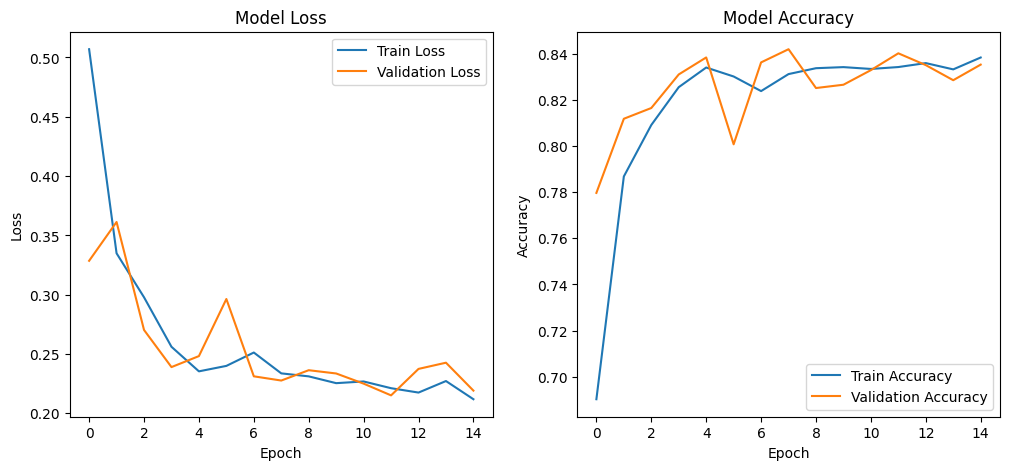

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Plot the last training history for the best model
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.show()

In [10]:
from sklearn.metrics import adjusted_rand_score

def rand_index(y_true, y_pred):
    # Flatten the arrays if necessary
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()
    y_pred = (y_pred > 0.5).astype(int)

    # Calculate Adjusted Rand Index using scikit-learn
    ari = adjusted_rand_score(y_true, y_pred)
    return ari
from sklearn.metrics import cohen_kappa_score

def cohen_kappa(y_true, y_pred):
    # Flatten the arrays if necessary
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()
    y_pred = (y_pred > 0.5).astype(int)

    # Calculate Cohen's Kappa using scikit-learn
    kappa = cohen_kappa_score(y_true, y_pred)
    return kappa


In [13]:
# Predict on validation set
y_pred_val = best_model.predict(X_val)
# Calculate Jaccard coefficient (IoU)
jaccard_score = jaccard_coef(y_val, y_pred_val)
print(f"Jaccard Coefficient (IoU): {jaccard_score}")
dice_Score=dice_coef(y_val,y_pred_val)
print(f"Dice Coefficient : {dice_Score}")
cohens=cohen_kappa(y_val,y_pred_val)
print(f"Cohen's Kappa  : {cohens}")
rand=rand_index(y_val,y_pred_val)
print(f"Rand index  : {rand}")


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
Jaccard Coefficient (IoU): 0.8997621953107611
Dice Coefficient : 0.9472366568107004
Cohen's Kappa  : 0.8162837541287117


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)


Rand index  : 0.6102785118842285


In [18]:
best_model.save('/content/drive/MyDrive/best_model_Grid_hehehe.h5')  # Save the model to Google Drive or any desired directory

print("Model saved successfully!")

Model saved successfully!
